# Práctica 1: PCA + Clustering 
* Autores: Luis Bueno y Yago Tobio 
* Dataset original: [Aircraft Wildlife Strikes 1990 - 2023 ](https://www.kaggle.com/datasets/dianaddx/aircraft-wildlife-strikes-1990-2023?resource=download)

---

# 1. Preprocesamiento para purificar el dataset

In [1]:
# * Librerías 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, silhouette_score
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, MiniBatchKMeans
from time import time
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib import cm

import matplotlib as mpl
import warnings
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

In [2]:
# Define la ruta del archivo Excel
ruta_archivo = 'STRIKE_REPORTS.csv'

# Carga el archivo Excel en un DataFrame de pandas
df = pd.read_csv(ruta_archivo)

/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_6773/1240123147.py:5: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo)


In [3]:
df.head()

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,6/22/1996,6,1996,NaN,NaN,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,Medium,NaN,NaN,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,6/26/1996,6,1996,NaN,NaN,KDEN,DENVER INTL AIRPORT,39.85841,-104.66700,...,Medium,NaN,NaN,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,7/1/1996,7,1996,NaN,NaN,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,...,Medium,NaN,NaN,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,7/1/1996,7,1996,NaN,NaN,KIAD,WASHINGTON DULLES INTL ARPT,38.94453,-77.45581,...,Medium,NaN,NaN,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,7/1/1996,7,1996,NaN,NaN,KLGA,LA GUARDIA ARPT,40.77724,-73.87261,...,Medium,NaN,NaN,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False


In [4]:

# * Seleccionamos las categorías que deseamos conservar en nuestro dataset
CATEGORICAL_COLUMNS = ['TIME_OF_DAY', 'AIRCRAFT', 'AC_MASS', 'PHASE_OF_FLIGHT', 'SPECIES', 'STATE', 'NUM_STRUCK'] 
NUMERICAL_COLUMNS = ['INCIDENT_YEAR', 'HEIGHT', 'SPEED', 'DISTANCE', 'COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ']
TOTAL_COLUMNS = CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS

In [5]:

# *  Elimina filas donde cualquiera de las columnas especificadas tenga un valor NaN
df = df.dropna(subset=['HEIGHT', 'SPEED', 'DISTANCE', 'NUM_STRUCK'])

# * Seleccionamos únicamente las columnas deseadas para nuestro analisis, PCA y Clustering
df = df[TOTAL_COLUMNS]
df.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ
5,Day,B-727-100,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0.0,100.0,0.0,NaN,NaN
11,Day,DC-9,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0.0,100.0,0.0,NaN,NaN
13,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0.0,120.0,0.0,NaN,NaN
16,Day,MD-80,4.0,Landing Roll,American kestrel,CA,1,1990,0.0,125.0,0.0,NaN,NaN
18,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0.0,140.0,0.0,NaN,NaN


Debido al voluminoso tamaño de nuestro conjunto de datos original, consideramos que es una práctica recomendable almacenar los datos ya depurados que emplearemos a lo largo del proyecto en un nuevo archivo con formato .xlsx

In [6]:
# Nombre del archivo de salida
nombre_archivo_salida = 'datos_limpios.xlsx'
df.to_excel(nombre_archivo_salida, index=False)

In [7]:
# Define la ruta del archivo Excel
ruta_archivo = 'datos_limpios.xlsx'

# Carga el archivo Excel en un DataFrame de pandas
df = pd.read_excel(ruta_archivo)
df.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ
0,Day,B-727-100,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0,100,0.0,NaN,NaN
1,Day,DC-9,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0,100,0.0,NaN,NaN
2,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0,120,0.0,NaN,NaN
3,Day,MD-80,4.0,Landing Roll,American kestrel,CA,1,1990,0,125,0.0,NaN,NaN
4,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0,140,0.0,NaN,NaN


In [8]:

# Assuming df is your DataFrame
# Convert 'COST_REPAIRS_INFL_ADJ' and 'COST_OTHER_INFL_ADJ' from string to numeric, removing commas
df['COST_REPAIRS_INFL_ADJ'] = pd.to_numeric(df['COST_REPAIRS_INFL_ADJ'].str.replace(',', ''), errors='coerce')
df['COST_OTHER_INFL_ADJ'] = pd.to_numeric(df['COST_OTHER_INFL_ADJ'].str.replace(',', ''), errors='coerce')

# Now, you can safely add these columns
df['COST_INFL_ADJ'] = df['COST_REPAIRS_INFL_ADJ'] + df['COST_OTHER_INFL_ADJ']
# Check the result
print(df['COST_INFL_ADJ'].value_counts())

COST_INFL_ADJ
14014.0     3
2510.0      3
8155.0      2
191100.0    2
105000.0    2
           ..
143115.0    1
170375.0    1
57246.0     1
13678.0     1
367.0       1
Name: count, Length: 657, dtype: int64


In [9]:
df = df.drop(columns=['COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ'])
df.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_INFL_ADJ
0,Day,B-727-100,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0,100,0.0,NaN
1,Day,DC-9,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0,100,0.0,NaN
2,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0,120,0.0,NaN
3,Day,MD-80,4.0,Landing Roll,American kestrel,CA,1,1990,0,125,0.0,NaN
4,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0,140,0.0,NaN


# 2.Analisis Explicativo del dataset (EDA): 

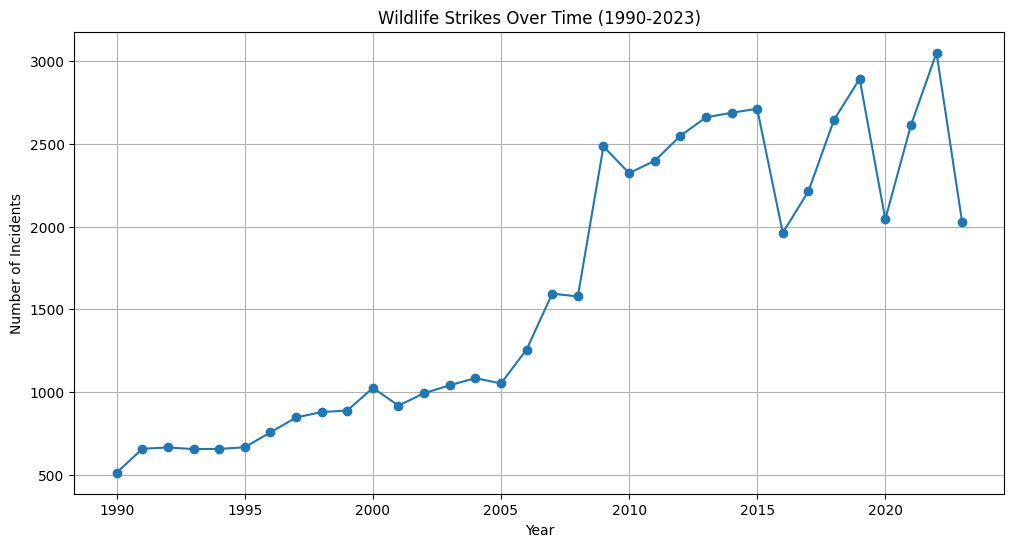

In [10]:
# Assuming df is your DataFrame after loading the dataset
# Plotting incidents over the years
yearly_trends = df.groupby('INCIDENT_YEAR').size()

plt.figure(figsize=(12, 6))
yearly_trends.plot(kind='line', marker='o')
plt.title('Wildlife Strikes Over Time (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()


In [11]:
state_accidents = df.groupby('STATE').size().reset_index(name='counts')
fig = px.choropleth(state_accidents,
                    locations='STATE', 
                    locationmode="USA-states", 
                    color='counts', 
                    color_continuous_scale="Viridis",
                    scope="usa",
                    labels={'counts':'Number of Incidents'}
                   )

fig.update_layout(title_text='Wildlife Strikes by State in the USA (1990-2023)')
fig.show()

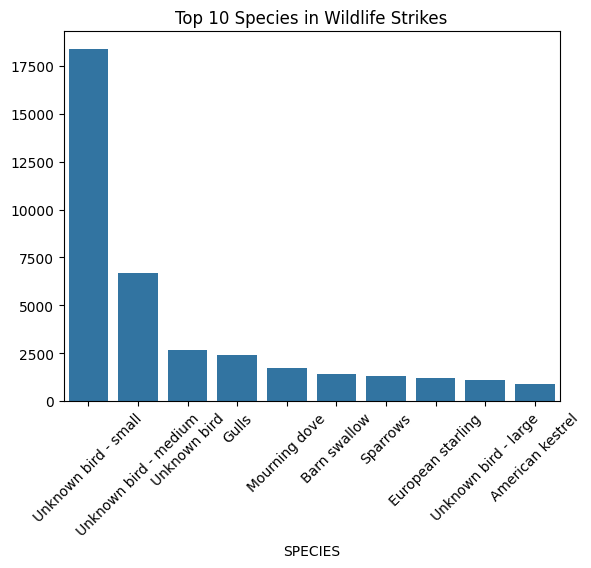

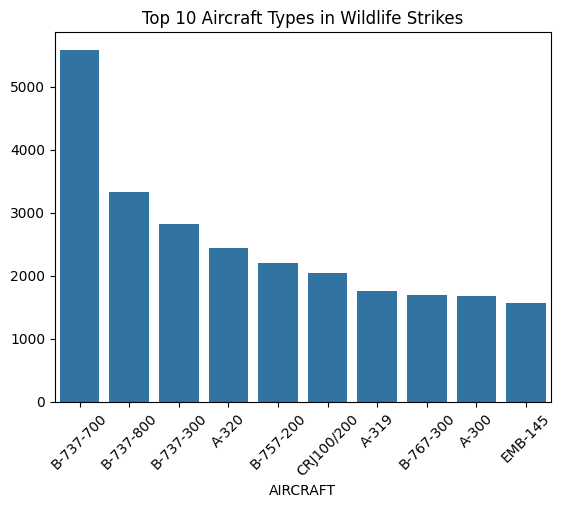

In [12]:
# Top 5 species involved in strikes
top_species = df['SPECIES'].value_counts().head(10)
sns.barplot(x=top_species.index, y=top_species.values)
plt.title('Top 10 Species in Wildlife Strikes')
plt.xticks(rotation=45)
plt.show()

# Aircraft types most involved in strikes
top_aircraft = df['AIRCRAFT'].value_counts().head(10)
sns.barplot(x=top_aircraft.index, y=top_aircraft.values)
plt.title('Top 10 Aircraft Types in Wildlife Strikes')
plt.xticks(rotation=45)
plt.show()

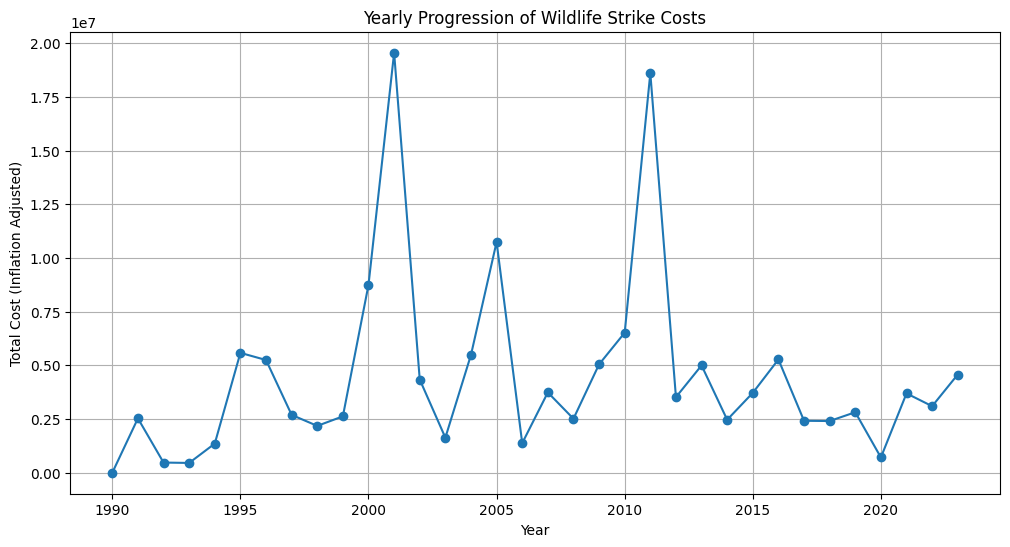

In [13]:
yearly_costs = df.groupby('INCIDENT_YEAR')['COST_INFL_ADJ'].sum()

plt.figure(figsize=(12, 6))
yearly_costs.plot(kind='line', marker='o')
plt.title('Yearly Progression of Wildlife Strike Costs')
plt.xlabel('Year')
plt.ylabel('Total Cost (Inflation Adjusted)')
plt.grid(True)
plt.show()

In [14]:
overall_cost = df['COST_INFL_ADJ'].sum()
print(f"Overall cost (Inflation Adjusted): {overall_cost}")

Overall cost (Inflation Adjusted): 151117411.0


That's $151M gone in damages caused by birds... Let that sink in. 

In [15]:
CATEGORICAL_COLUMNS = ['TIME_OF_DAY', 'AIRCRAFT', 'AC_MASS', 'PHASE_OF_FLIGHT', 'SPECIES', 'NUM_STRUCK']
NUMERICAL_COLUMNS = ['INCIDENT_YEAR', 'HEIGHT', 'SPEED', 'DISTANCE', 'COST_INFL_ADJ']
# Análisis de la distribución de categorías
for i, column in enumerate(CATEGORICAL_COLUMNS, 1): 
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n")

Column: TIME_OF_DAY
TIME_OF_DAY
Day      33688
Night    14241
Dusk      2575
Dawn      2016
Name: count, dtype: int64


Column: AIRCRAFT
AIRCRAFT
B-737-700                5586
B-737-800                3331
B-737-300                2816
A-320                    2438
B-757-200                2209
                         ... 
F-15E                       1
NORTH AMERICAN              1
CESSNA LC-41                1
BRITISH AEROSPACE           1
NORTH AMERICAN OV-10A       1
Name: count, Length: 453, dtype: int64


Column: AC_MASS
AC_MASS
4.0    37625
3.0     9633
1.0     3572
2.0     3526
5.0      399
Name: count, dtype: int64


Column: PHASE_OF_FLIGHT
PHASE_OF_FLIGHT
Approach        22484
Take-off Run    12474
Landing Roll    11943
Climb            7210
Descent           494
Taxi              151
Local             138
Parked             33
En Route            1
Name: count, dtype: int64


Column: SPECIES
SPECIES
Unknown bird - small     18384
Unknown bird - medium     6704
Unknown bird  

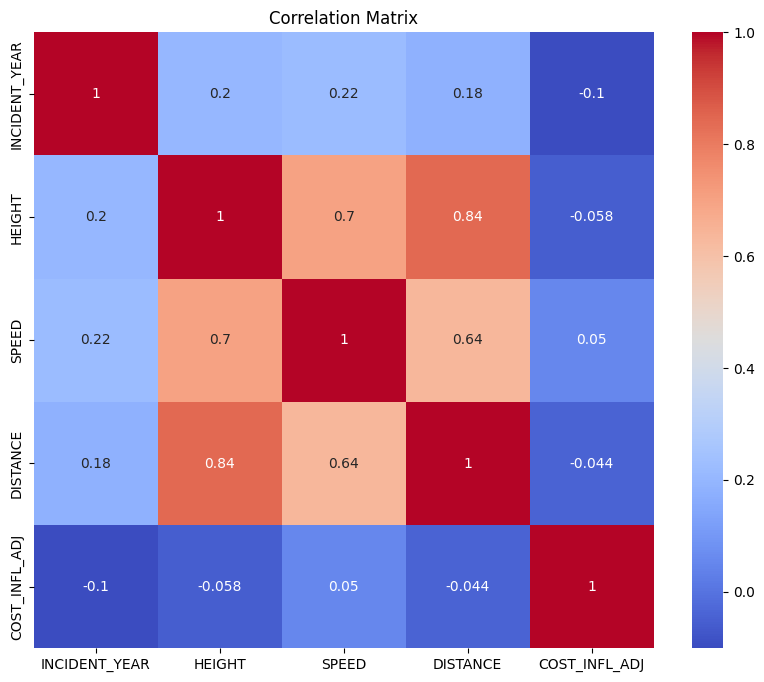

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[NUMERICAL_COLUMNS].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

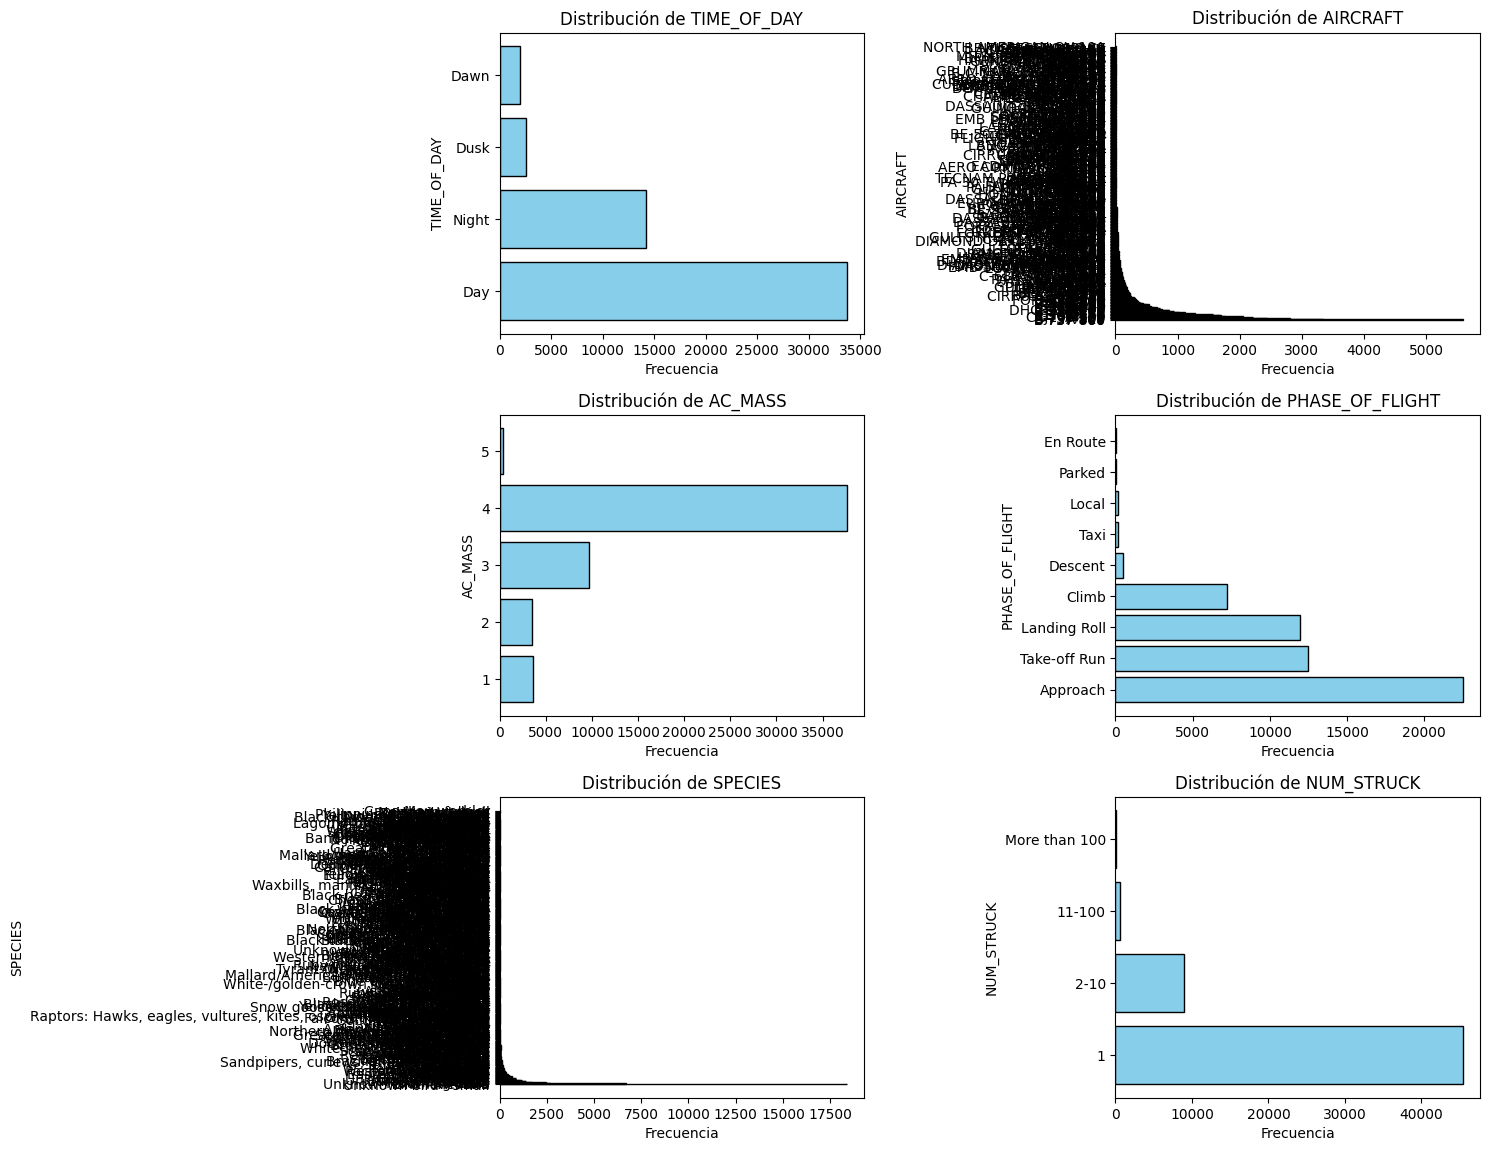

In [17]:

# * Análisis de la distribución de columnas categóricas 
plt.figure(figsize=(15, 15))

for i, column in enumerate(CATEGORICAL_COLUMNS, 1):
    # Calculate the frequencies of each category
    value_counts = df[column].value_counts()
    # Create a horizontal bar chart
    plt.subplot(4, 2, i)  # Adjust the grid dimensions as needed
    plt.barh(value_counts.index, value_counts, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel('Frecuencia')
    plt.ylabel(column)
    
plt.tight_layout()
plt.show()

De las graficas de arriba, podemos observar que existe un gran desfase de clases - particularmente con la columna de SPECIES, AIRPORT_ID y AIRCRAFT. 
Con el fin de equilibrar las clases y seleccionar los datos más relevantes, vamos a generar una tabla la cual cojan datos de hasta el cuartil 75 dentro de toda la distribución y evitar casos extremos. 

Para aquellas otras categorías como AC_MASS, PHASE_OF_FLIGHT, TIME_OF_DAY, procederemos a equilibrar las clases mediante SMOTE. 

----

# Equilibrio de Clases

Debido al gran numero de especies de animal, y aviones ...

In [18]:
# Encontrar las 14 categorías más comunes
top_14_species = df['SPECIES'].value_counts().head(14).index

# Reemplazar todas las otras categorías por 'Other species'
df['SPECIES'] = df['SPECIES'].apply(lambda x: x if x in top_14_species else 'Other species')

# Verificar el resultado
print('DataFrame con categorías agrupadas:')
print(df['SPECIES'].value_counts())


DataFrame con categorías agrupadas:
SPECIES
Unknown bird - small     18384
Other species            14117
Unknown bird - medium     6704
Unknown bird              2647
Gulls                     2428
Mourning dove             1708
Barn swallow              1409
Sparrows                  1316
European starling         1187
Unknown bird - large      1103
American kestrel           867
Killdeer                   858
Rock pigeon                856
Red-tailed hawk            750
Canada goose               662
Name: count, dtype: int64


In [19]:
# Encontrar las 19 categorías más comunes
top_19_aircraft = df['AIRCRAFT'].value_counts().head(19).index

# Reemplazar todas las otras categorías por 'Other species'
df['AIRCRAFT'] = df['AIRCRAFT'].apply(lambda x: x if x in top_19_aircraft else 'Other aircrafts')

# Verificar el resultado
print('DataFrame con categorías agrupadas:')
print(df['AIRCRAFT'].value_counts())

DataFrame con categorías agrupadas:
AIRCRAFT
Other aircrafts    21213
B-737-700           5586
B-737-800           3331
B-737-300           2816
A-320               2438
B-757-200           2209
CRJ100/200          2046
A-319               1755
B-767-300           1700
A-300               1682
EMB-145             1562
EMB-170             1277
MD-82               1118
A-321               1116
C-172               1014
B-717-200            945
B-737-200            859
MD-11                855
DHC8 DASH 8          756
B-727-200            718
Name: count, dtype: int64


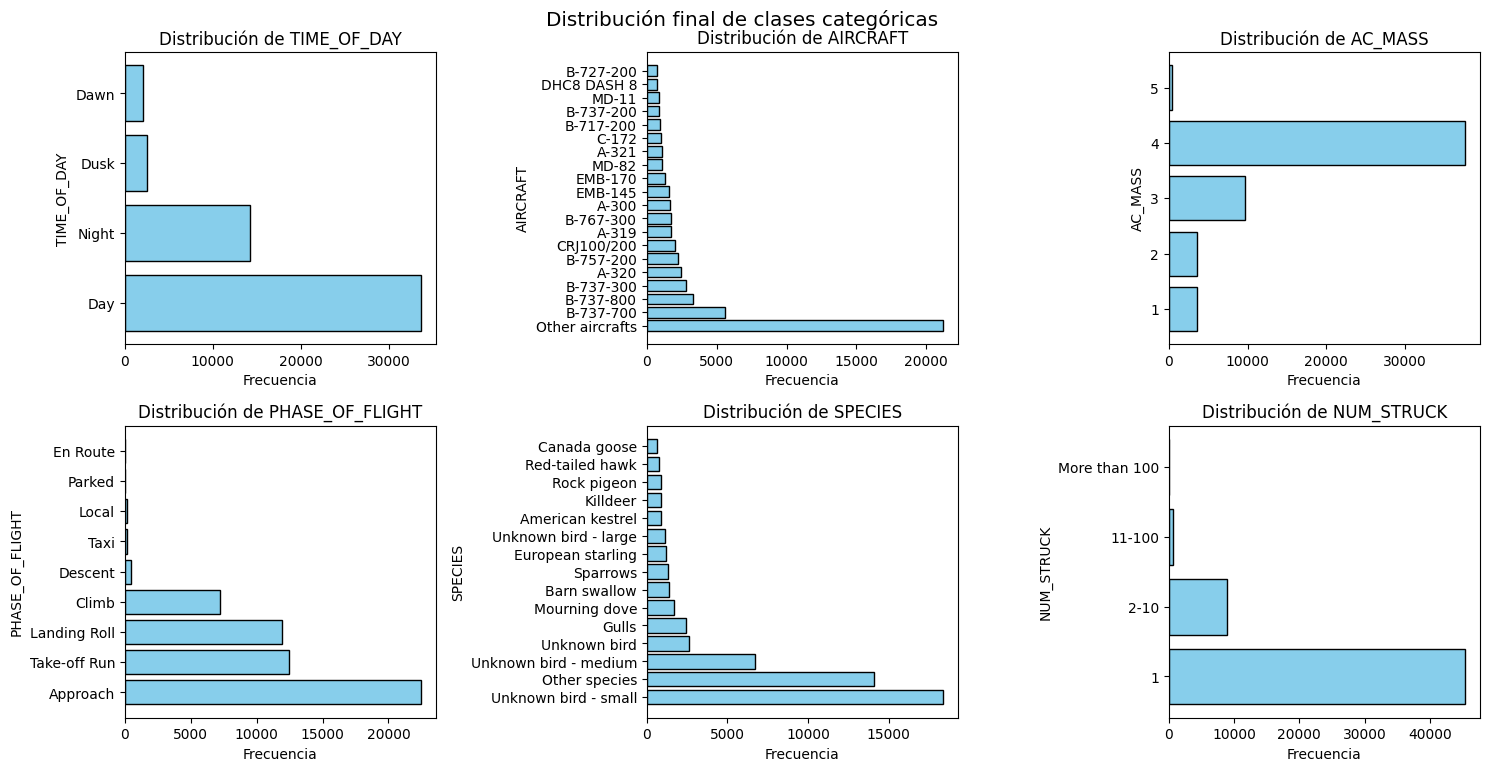

In [20]:

# * Análisis de la distribución de columnas categóricas 
plt.figure(figsize=(15, 15))
plt.suptitle("Distribución final de clases categóricas ", fontsize="x-large")
for i, column in enumerate(CATEGORICAL_COLUMNS, 1):
    # Calculate the frequencies of each category
    value_counts = df[column].value_counts()
    # Create a horizontal bar chart
    plt.subplot(4, 3, i)  # Adjust the grid dimensions as needed
    plt.barh(value_counts.index, value_counts, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel('Frecuencia')
    plt.ylabel(column)
    
plt.tight_layout()
plt.show()

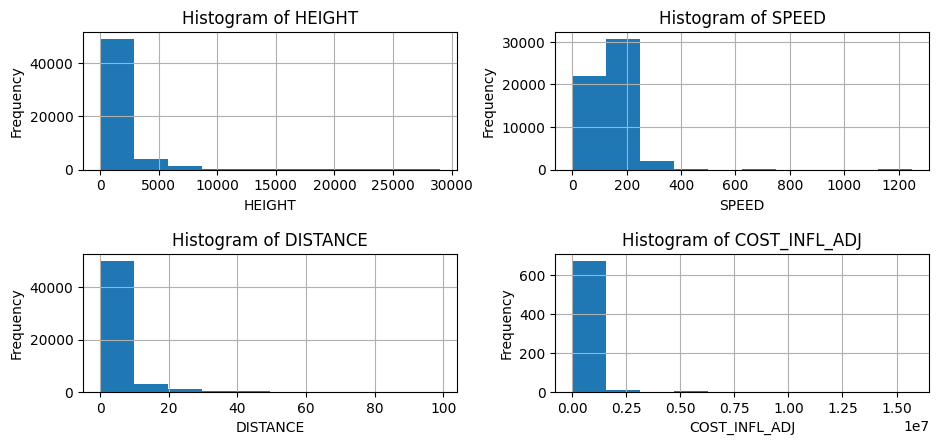

In [21]:
# Filter out 'INCIDENT_YEAR' from your columns list
num_cols = ['HEIGHT', 'SPEED', 'DISTANCE', 'COST_INFL_ADJ']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
fig.tight_layout(pad=4.0)

axes = axes.flatten()

# Iterate over each column and plot its histogram
for i, col in enumerate(num_cols):
    # Select the axis for plotting
    ax = axes[i]
    # Plot histogram
    df[col].hist(ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Display the plots
plt.show()


**On the topic of COST_INFL_ADJ:**

Due to the datasets nature, we're going to interpret that all COST_INFL_ADJ rows which are empty (aka: NaN), are those that where not filled in. Thus, we will replace the NaN's with 0. While this might prove to be innacurate, it will be a better solution for this project to maintain the large data volume intact. 

Deleting the NaN rows would make our data pass from over 54000 rows, to just above 1000.

In [22]:
df['COST_INFL_ADJ'] = df['COST_INFL_ADJ'].fillna(0)

----

# PCA

Para poder efectuar un Principal Component Analysis, deseamos intentar predecir el tipo de animal que tuvo un accidente junto a nuestro avión. Ya que es la información que más dificil tenemos la posibilidad de averiguar.

Con la información que tenemos sabiendo el tipo de avión, estado, año, y distancia, podremos observar los patrones con el fin de evitar dichos daños y evitar tener que gastar más dinero. 

In [23]:
df_pca = df.copy() # * We take a copy of the dataset for distinct modifications when it comes to clustering.  
df_pca.head()
#print(len(NUMERICAL_COLUMNS)) - 5
#print(len(CATEGORICAL_COLUMNS)) - 6

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_INFL_ADJ
0,Day,Other aircrafts,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0,100,0.0,0.0
1,Day,Other aircrafts,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0,100,0.0,0.0
2,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0,120,0.0,0.0
3,Day,Other aircrafts,4.0,Landing Roll,American kestrel,CA,1,1990,0,125,0.0,0.0
4,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0,140,0.0,0.0


PCA should only be applied to the numerical variables. So we will only consider AC_MASS, NUM_STRUCK, INCIDENT_YEAR, HEIGHT, SPEED, DISTANCE, COST_INFL_ADJ. Moreover, we will change our output target column into labels. 

In [24]:
encoder = LabelEncoder()
df_pca['SPECIES_ENCODED'] = encoder.fit_transform(df['SPECIES'])
df_pca = df_pca.drop(columns=['SPECIES'])

In [25]:
NUMERICAL_COLUMNS.append('SPECIES_ENCODED')
X = df_pca[NUMERICAL_COLUMNS]
X = X.drop(columns=['COST_INFL_ADJ'])
y = df_pca.COST_INFL_ADJ # * Continuous data for the darget

In [26]:
X.head()

,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,SPECIES_ENCODED
0,1991,0,100,0.0,13
1,1990,0,100,0.0,14
2,1993,0,120,0.0,14
3,1990,0,125,0.0,0
4,1995,0,140,0.0,13


In [27]:
X.shape, y.shape

((54996, 5), (54996,))

### Steps for PCA once the dataset has been prepared: 
+ Split the data into train and test datasets. 
+ Apply the Standard scaler. 
+ Find out the optimal number of dimensions to reduce the numerical data to using Scree Plots
+ Apply PCA. 
+ Visualise the information + Extract the eigenvectors

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [29]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [30]:
# Reconstruction error on MNIST vs number of latent dimensions used by PCA
# * This is dimension D
X_rank = np.linalg.matrix_rank(X_train) 

# * Generate the K's vector - To test out for the optimal L. 
Ks = [1,2,3,4]

# ? - Vectors which are intended to store the RMSE values for train and test datasets.
RMSE_train = np.arange(len(Ks))
RMSE_test = np.arange(len(Ks))

In [31]:

# * For each L which we want to test out perform a PCA and it's corresponding reconstruction 
# * Both for the train & test datasets - Then for that specific L, log what the RMS error is in order to plot it. 
for index, K in enumerate(Ks):
    pca = PCA(n_components=K)

    Xtrain_transformed = pca.fit_transform(X_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train[index] = mean_squared_error(X_train, Xtrain_proj, squared=False)

    Xtest_transformed = pca.transform(X_test)
    Xtest_proj = pca.inverse_transform(Xtest_transformed)
    RMSE_test[index] = mean_squared_error(X_test, Xtest_proj, squared=False)

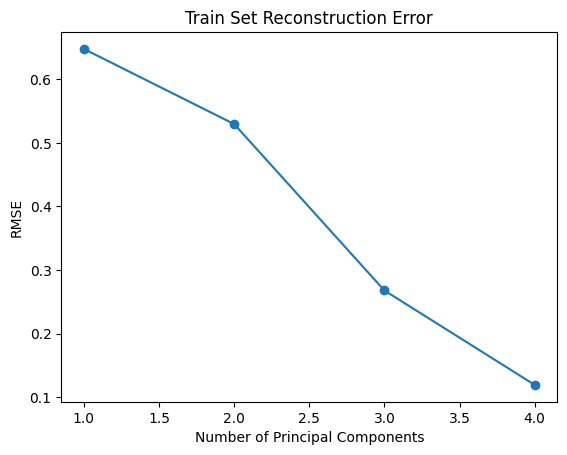

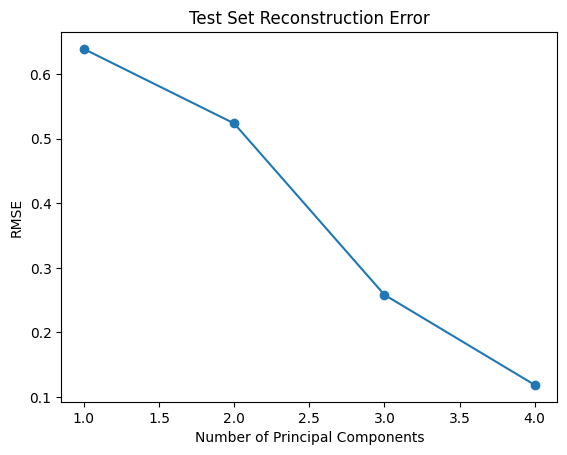

In [32]:
# Assuming X_train and X_test are defined
max_components = min(X_train.shape[0], X_train.shape[1]) - 1
Ks = list(range(1, max_components + 1))  # Dynamically setting the range based on dataset size

RMSE_train = np.zeros(len(Ks), dtype=float)
RMSE_test = np.zeros(len(Ks), dtype=float)

for index, K in enumerate(Ks):
    pca = PCA(n_components=K)
    Xtrain_transformed = pca.fit_transform(X_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train[index] = mean_squared_error(X_train, Xtrain_proj, squared=False)

    Xtest_transformed = pca.transform(X_test)
    Xtest_proj = pca.inverse_transform(Xtest_transformed)
    RMSE_test[index] = mean_squared_error(X_test, Xtest_proj, squared=False)

# Plot for training set
fig, ax = plt.subplots()
ax.plot(Ks, RMSE_train, marker="o")
plt.title("Train Set Reconstruction Error")
plt.xlabel("Number of Principal Components")
plt.ylabel("RMSE")
plt.show()

# Plot for test set
fig, ax = plt.subplots()
ax.plot(Ks, RMSE_test, marker="o")
plt.title("Test Set Reconstruction Error")
plt.xlabel("Number of Principal Components")
plt.ylabel("RMSE")
plt.show()


In [33]:
# * Fraction of variance explained
pca = PCA(n_components=X_rank)
# ? - This is part of the Scree Plot which is mentioned in the slides.  
X_transformed = pca.fit_transform(X_train)
evals = pca.explained_variance_  # eigenvalues in descending order
# ? - We're limite the number of dimensions to 50 as a maximum
fraction_var = np.cumsum(evals[0:5] / np.sum(evals))

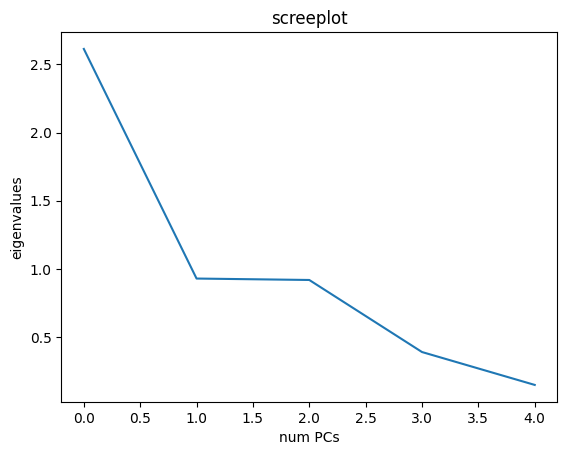

In [34]:
fig, ax = plt.subplots()
xs = np.arange(0, 5)
ys = evals[0:5]
plt.title("screeplot")
plt.xlabel("num PCs")
plt.ylabel("eigenvalues")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.plot(xs, ys)
plt.show()

In [35]:
pca = PCA(n_components = 2)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

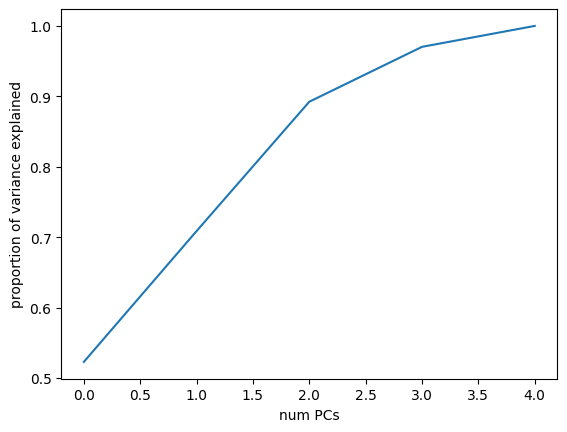

In [36]:
fig, ax = plt.subplots()
xs = np.arange(0, 5)
ys = fraction_var
plt.xlabel("num PCs")
plt.ylabel("proportion of variance explained")
ax.plot(xs, ys)
plt.show()

## Log likelihood

In [37]:
 # * Profile Likelihood
def log_likelihood(evals):
    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):

        group1 = evals[0 : L + 1]  # Divide Eigenvalues in two groups
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        # eqn (20.30)
        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2  
    return ll

In [38]:
ll = log_likelihood(evals) # * Insert all of the corresponding eigenvalues. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



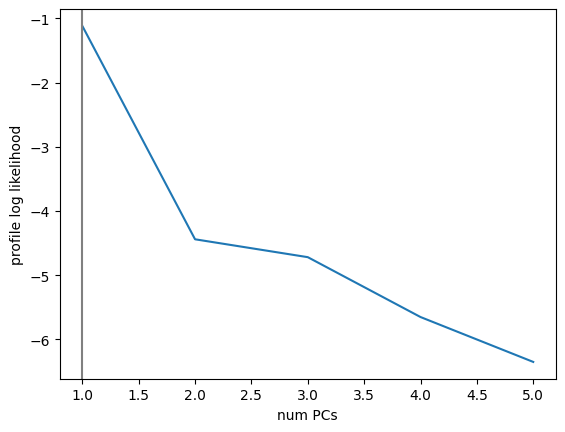

In [39]:
fig, ax = plt.subplots()
xs = np.arange(1, 6)
ys = ll[0:50]

plt.xlabel("num PCs")
plt.ylabel("profile log likelihood")
plt.plot(xs, ys)
idx = np.argmax(ys)
plt.axvline(xs[idx], c='grey')
plt.show()

In [40]:
# Perform PCA
n_components = 2 
pca = PCA(n_components=n_components)
pca.fit(X_train)

# Access the matrix W of eigenvectors (principal components)
W = pca.components_
print("Matrix W (Eigenvectors/Principal Components):")
print(W)

# Access the eigenvalues (explained variance)
eigenvalues = pca.explained_variance_
print("Eigenvalues (Explained Variance):")
print(eigenvalues)

# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

Matrix W (Eigenvectors/Principal Components):
[[ 2.14721163e-01  5.70540313e-01  5.24682910e-01  5.52568530e-01
   2.18527887e-01]
 [ 7.43705777e-01 -1.36570388e-04 -1.58622697e-02 -9.51426317e-03
  -6.68251125e-01]]
Eigenvalues (Explained Variance):
[2.61400376 0.92909596]
Explained Variance Ratio:
[0.52278887 0.18581497]


In [41]:
pca.components_

array([[ 2.14721163e-01,  5.70540313e-01,  5.24682910e-01,
         5.52568530e-01,  2.18527887e-01],
       [ 7.43705777e-01, -1.36570388e-04, -1.58622697e-02,
        -9.51426317e-03, -6.68251125e-01]])

In [46]:
NUMERICAL_COLUMNS.remove('COST_INFL_ADJ')

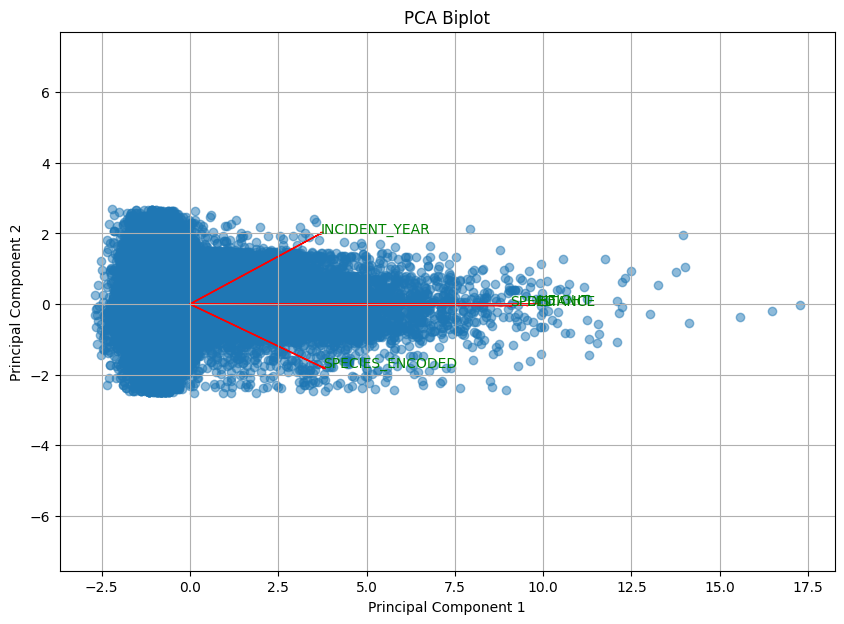

In [47]:
# Plot the PCA scores
plt.figure(figsize=(10, 7))
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], alpha=0.5)

# Plot the loadings (arrows)
for i, feature in enumerate(NUMERICAL_COLUMNS):  # Assume 'features' is your list of feature names
    plt.arrow(0, 0, pca.components_[0, i]*max(X_pca_train[:,0]), pca.components_[1, i]*max(X_pca_train[:,1]),
              color='r', width=0.005, head_width=0.05)
    plt.text(pca.components_[0, i]*max(X_pca_train[:,0]), pca.components_[1, i]*max(X_pca_train[:,1]),
             feature, color='g')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot')
plt.grid(True)
plt.axis('equal')  # Equal scaling on both axes for proper arrow representation
plt.show()


In [48]:
# Principal components correlation coefficients
loadings = pca.components_

# Number of features before PCA
n_features = pca.n_features_in_
 
# Feature names before PCA
feature_names = NUMERICAL_COLUMNS
 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2
feature_names,,
INCIDENT_YEAR,0.214721,0.743706
HEIGHT,0.570540,-0.000137
SPEED,0.524683,-0.015862
DISTANCE,0.552569,-0.009514
SPECIES_ENCODED,0.218528,-0.668251


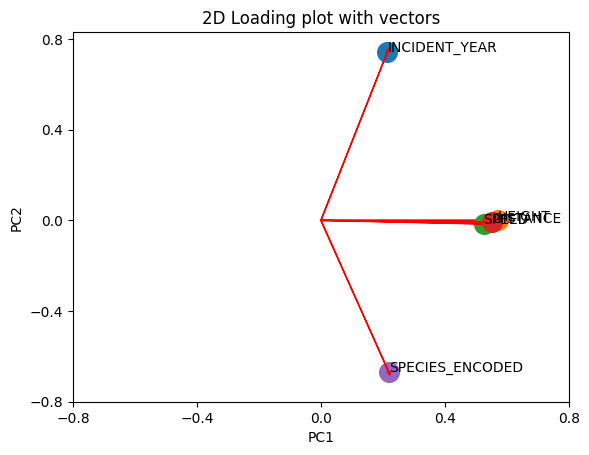

In [49]:
# Get the loadings of x and y axes
xs = loadings[0]
ys = loadings[1]
 
# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='r', 
        head_width=0.01
        )
    plt.text(xs[i], ys[i], varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('2D Loading plot with vectors')
plt.show()

----
# Clustering 

In [50]:
df_clustering = df.copy()
df_clustering.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_INFL_ADJ
0,Day,Other aircrafts,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0,100,0.0,0.0
1,Day,Other aircrafts,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0,100,0.0,0.0
2,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0,120,0.0,0.0
3,Day,Other aircrafts,4.0,Landing Roll,American kestrel,CA,1,1990,0,125,0.0,0.0
4,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0,140,0.0,0.0


In [51]:

# Codificación one-hot para variables categóricas
encoder = OneHotEncoder()  # No especificamos 'sparse' aquí
encoded_categorical_columns = encoder.fit_transform(df[CATEGORICAL_COLUMNS]).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical_columns, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS))

# Normalización de variables numéricas
scaler = StandardScaler()
scaled_numerical_columns = scaler.fit_transform(df[NUMERICAL_COLUMNS])
scaled_numerical_df = pd.DataFrame(scaled_numerical_columns, columns=NUMERICAL_COLUMNS)

# Combinando los datos codificados y escalados de nuevo en un solo DataFrame
prepared_df = pd.concat([encoded_categorical_df, scaled_numerical_df], axis=1)

NameError: name 'OneHotEncoder' is not defined

In [ ]:
prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54996 entries, 0 to 54995
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   TIME_OF_DAY_Dawn               54996 non-null  float64
 1   TIME_OF_DAY_Day                54996 non-null  float64
 2   TIME_OF_DAY_Dusk               54996 non-null  float64
 3   TIME_OF_DAY_Night              54996 non-null  float64
 4   TIME_OF_DAY_nan                54996 non-null  float64
 5   AIRCRAFT_A-300                 54996 non-null  float64
 6   AIRCRAFT_A-319                 54996 non-null  float64
 7   AIRCRAFT_A-320                 54996 non-null  float64
 8   AIRCRAFT_A-321                 54996 non-null  float64
 9   AIRCRAFT_B-717-200             54996 non-null  float64
 10  AIRCRAFT_B-727-200             54996 non-null  float64
 11  AIRCRAFT_B-737-200             54996 non-null  float64
 12  AIRCRAFT_B-737-300             54996 non-null 

## Elbow Method

In [ ]:
inertias = []

# Rango de valores de k para probar
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(prepared_df)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, '-o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters, k')
plt.ylabel('Inercia')
plt.xticks(k_values)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
    
KeyboardInterrupt: 
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:



Observamos un cambio en tendencia en k = 2 y k = 5. Lo consideraremos para elegir el número de clusters. 

## Silhouette

In [ ]:
Ks = range(2, 12)
# inertia = distorsion
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(prepared_df) for k in Ks]
inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(prepared_df, model.labels_) for model in kmeans_per_k]

KeyboardInterrupt: 

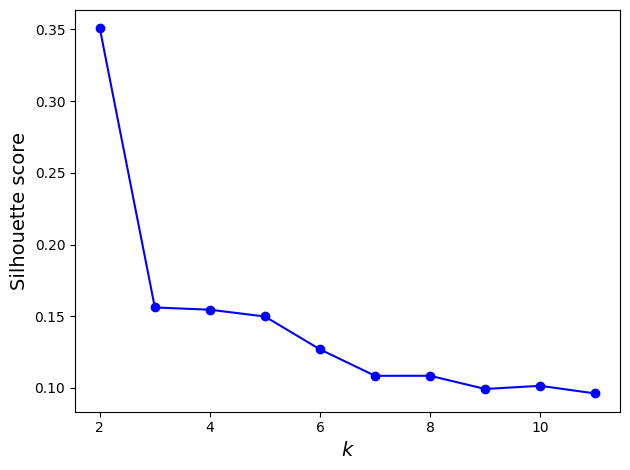

In [ ]:
plt.figure()
plt.plot(Ks, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.tight_layout()
plt.show()

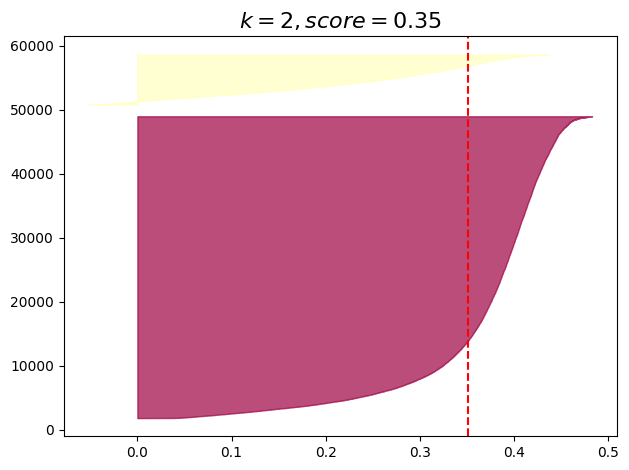

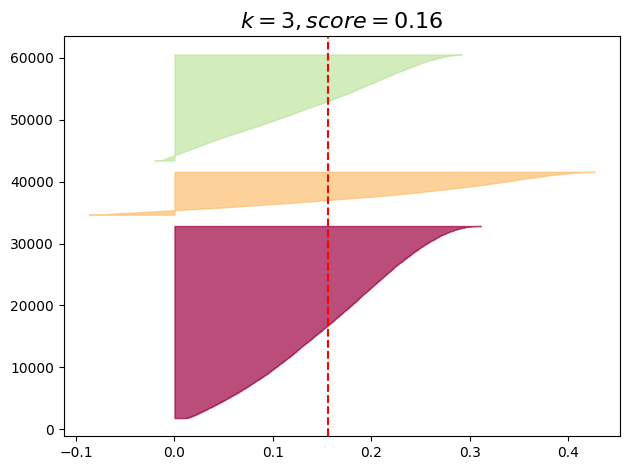

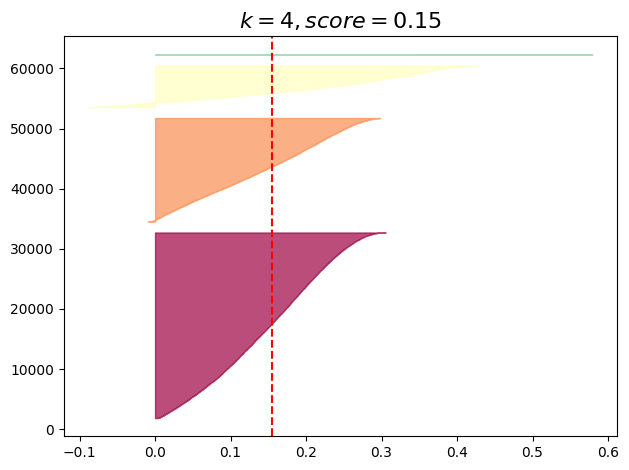

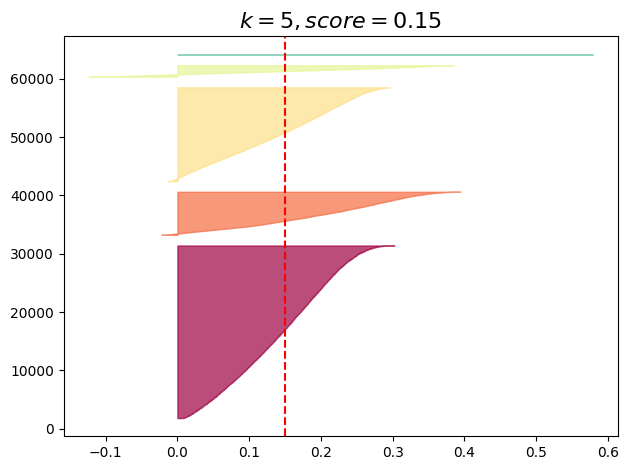

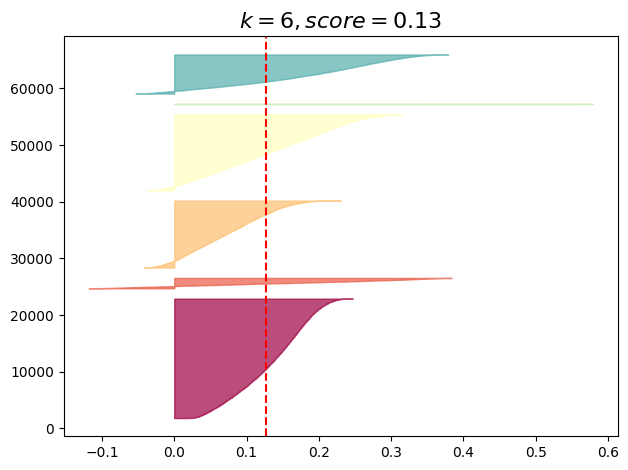

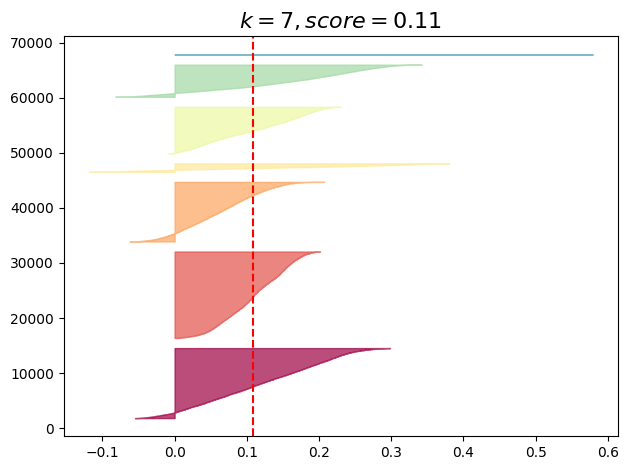

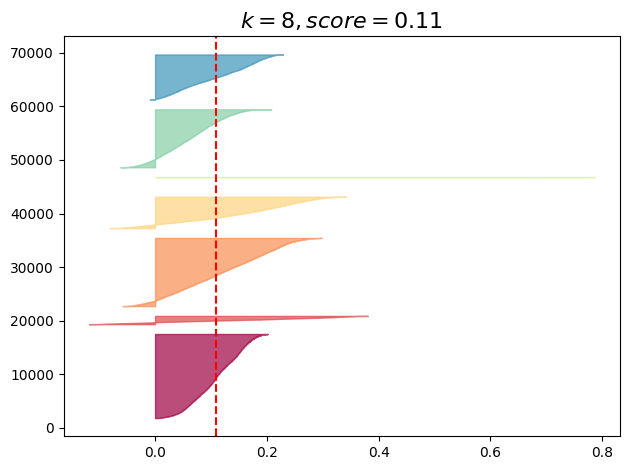

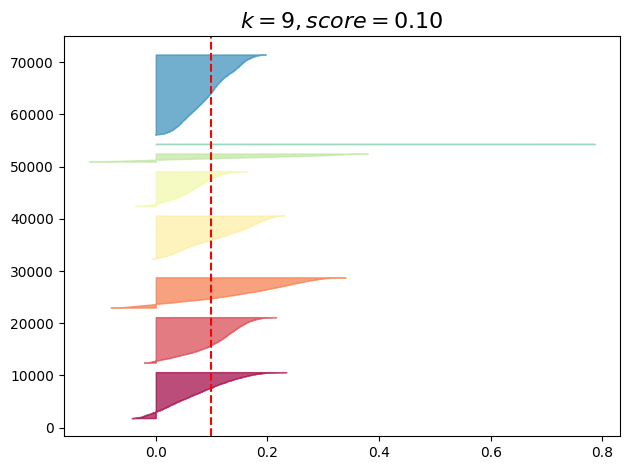

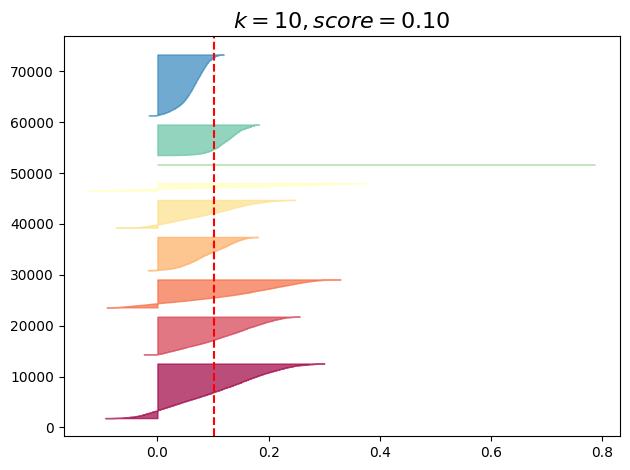

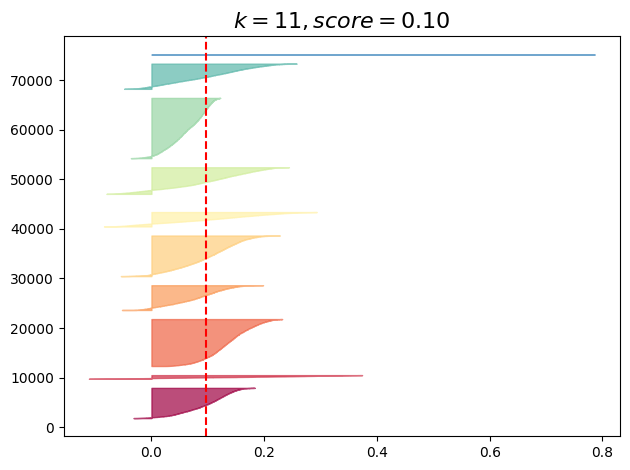

In [ ]:
warnings.filterwarnings("ignore")

def plot_silhouette(model, X):
    mu = model.cluster_centers_
    K, D = mu.shape
    y_pred = model.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_scores = silhouette_score(X, model.labels_)
    cmap = cm.get_cmap("Pastel2")
    colors = [cmap(i) for i in range(K)]
    padding = len(X) // 30
    pos = padding
    for i in range(K):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / K)
        # color = colors[i]
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        pos += len(coeffs) + padding
    score = silhouette_scores
    plt.axvline(x=score, color="red", linestyle="--")
    plt.title("$k={}, score={:0.2f}$".format(K, score), fontsize=16)


for model in kmeans_per_k:
    K, D = model.cluster_centers_.shape
    plt.figure()
    plot_silhouette(model, prepared_df)
    fname = f"kmeans_silhouette_diagram{K}.pdf"
    plt.tight_layout()

Parece que siguiendo el codo k=2 y k=5 son adecuados pero en silhouette k=2 parece mejor.

In [ ]:
# Ajuste del modelo K-Means
kmeans = KMeans(n_clusters=2)
kmeans.fit(prepared_df)

# Etiquetas de cluster para cada punto
labels = kmeans.labels_

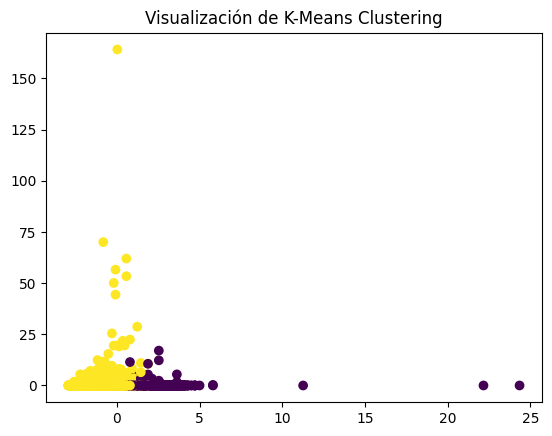

In [ ]:
# Visualización (asumiendo 2D, ajusta según tus necesidades)
plt.scatter(prepared_df.iloc[:, 62], prepared_df.iloc[:,64], c=labels)
plt.title("Visualización de K-Means Clustering")
plt.show()

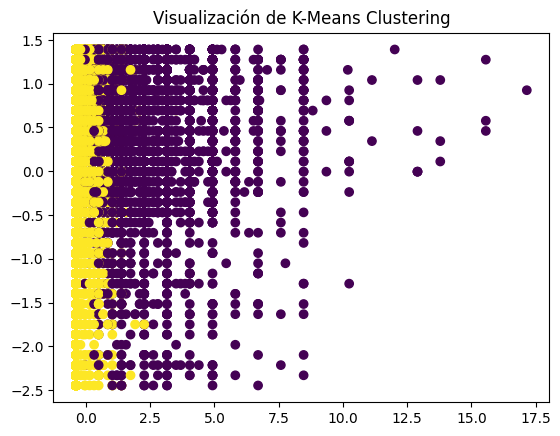

In [ ]:
# Visualización (asumiendo 2D, ajusta según tus necesidades)
plt.scatter(prepared_df.iloc[:, 63], prepared_df.iloc[:,60], c=labels)
plt.title("Visualización de K-Means Clustering")
plt.show()

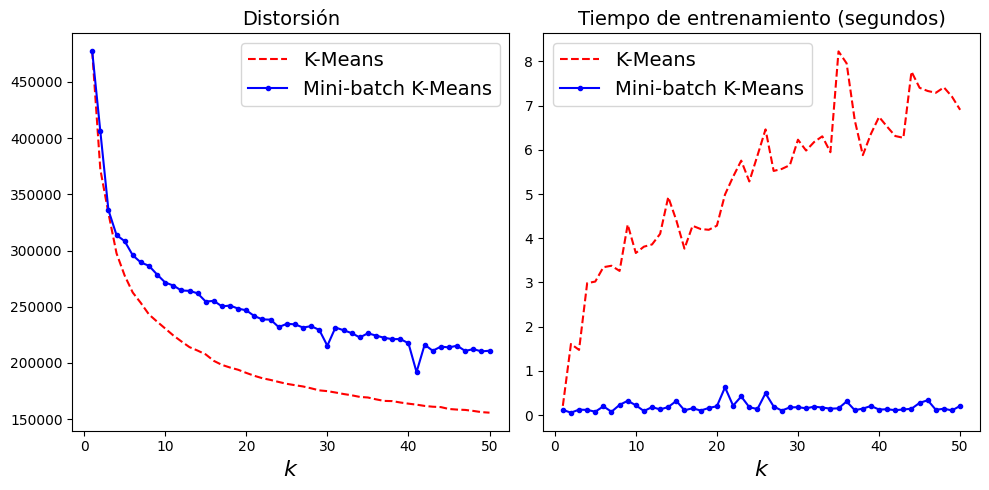

In [ ]:
K = 50
times = np.empty((K, 2))
inertias = np.empty((K, 2))

for k in range(1, K + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    
    start = time()
    kmeans.fit(prepared_df)
    times[k - 1, 0] = time() - start
    inertias[k - 1, 0] = kmeans.inertia_
    
    start = time()
    minibatch_kmeans.fit(prepared_df)
    times[k - 1, 1] = time() - start
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

# Graficar la inercia y los tiempos de entrenamiento
plt.figure(figsize=(10, 5))

# Subplot para la inercia/distorsión
plt.subplot(121)
plt.plot(range(1, K + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, K + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Distorsión", fontsize=14)
plt.legend(fontsize=14)

# Subplot para el tiempo de entrenamiento
plt.subplot(122)
plt.plot(range(1, K + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, K + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Tiempo de entrenamiento (segundos)", fontsize=14)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

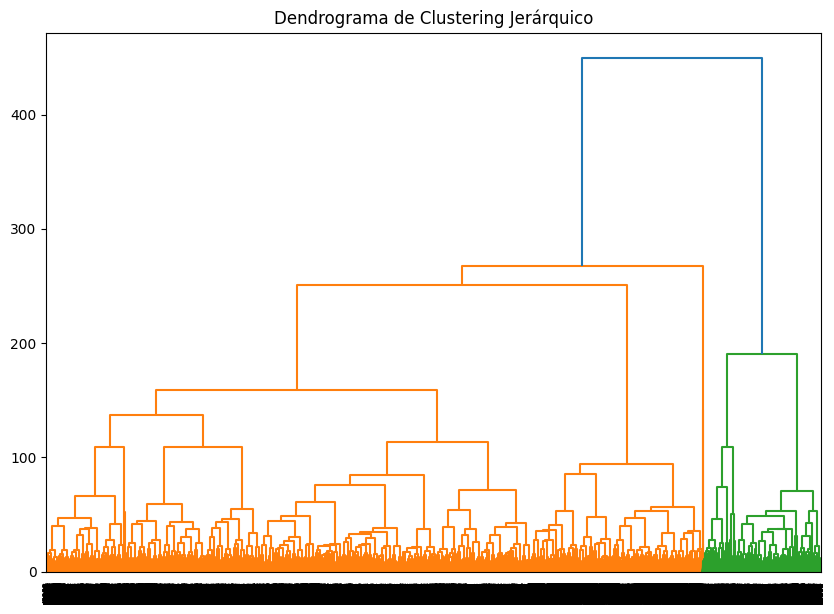

In [ ]:
# Generación del linkage
linked = linkage(prepared_df, method='ward')

# Visualización del dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Dendrograma de Clustering Jerárquico")
plt.show()

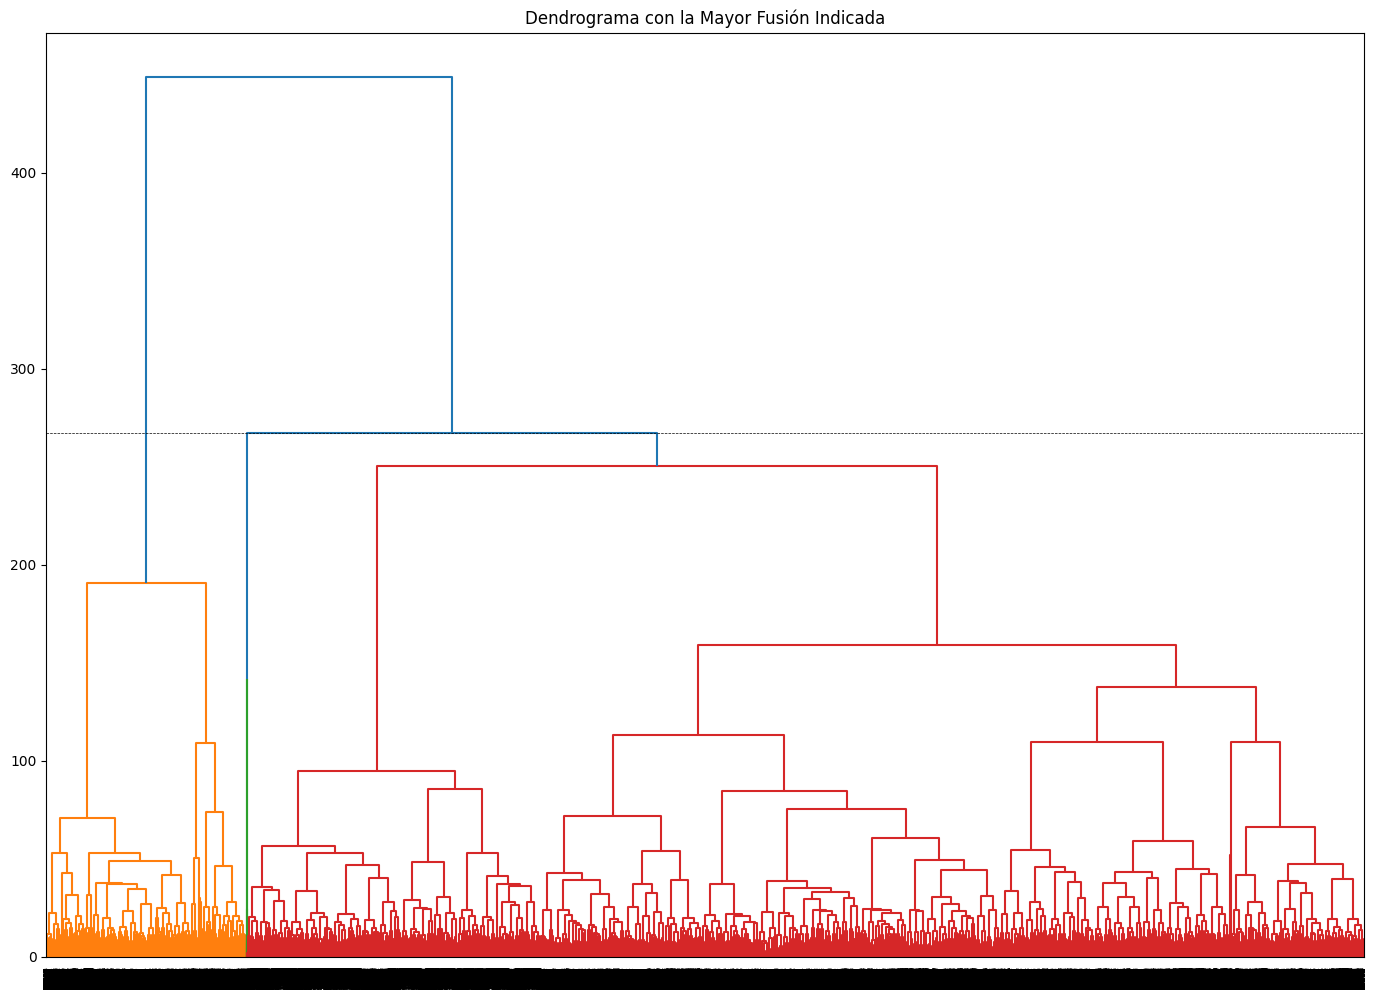

In [ ]:
distances = linked[:, 2]
# Calcular los incrementos de distancia entre fusiones sucesivas
increments = np.diff(distances)

# Identificar la fusión con el mayor incremento en distancia
largest_increment_index = np.argmax(increments)
# La distancia en la que ocurre esta fusión
largest_increment_distance = distances[largest_increment_index]

# Visualización del dendrograma con una línea que indica la fusión más grande
plt.figure(figsize=(17, 12))
dendrogram(linked, orientation='top', color_threshold=largest_increment_distance)
plt.axhline(y=largest_increment_distance, c='k', ls='--', lw=0.5)
plt.title("Dendrograma con la Mayor Fusión Indicada")
plt.show()

# Esta distancia sugiere un buen punto de corte para obtener dos clusters

Una esfera no tiene porque ser la mejor forma de agrupar los datos, por eso probamos también:

## Gaussian Mixture Model GMM

Miramos el BIC y AIC para saber el número de componentes. Esto mide la calidad del modelo teniendo en cuenta la penalización por la cantidad de parámetros

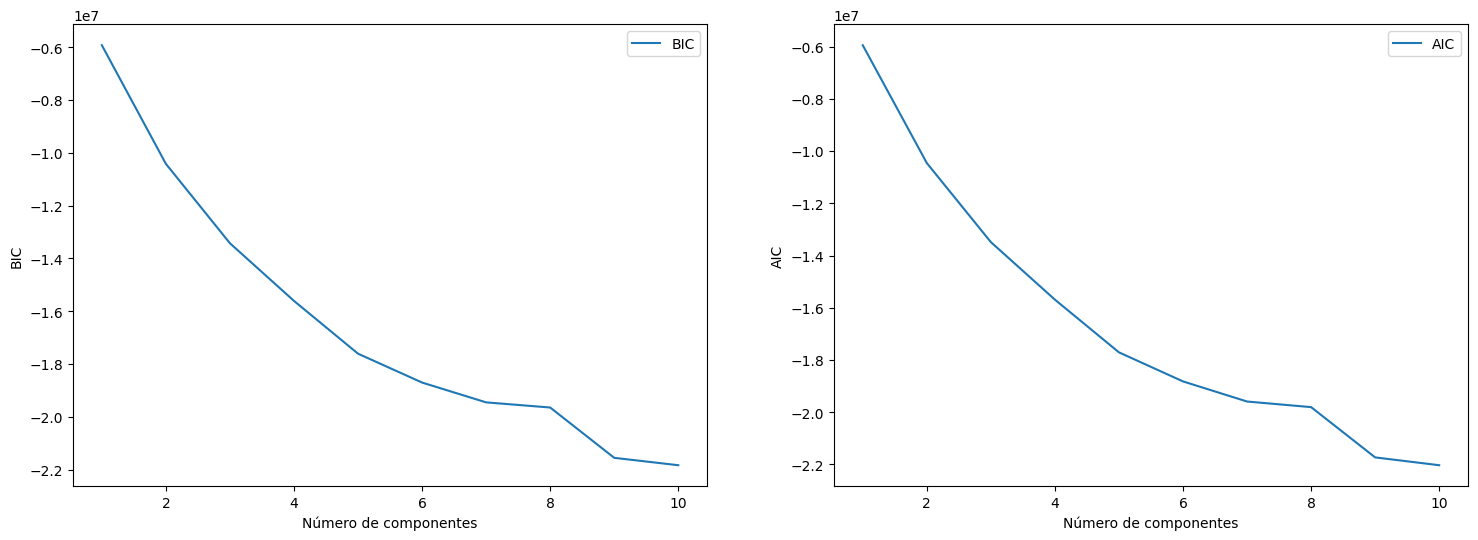

In [ ]:
n_components_range = range(1, 11)
bics = []
aics = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(prepared_df)
    bics.append(gmm.bic(prepared_df))
    aics.append(gmm.aic(prepared_df))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot(n_components_range, bics, label='BIC')
plt.xlabel('Número de componentes')
plt.ylabel('BIC')
plt.legend()

plt.subplot(122)
plt.plot(n_components_range, aics, label='AIC')
plt.xlabel('Número de componentes')
plt.ylabel('AIC')
plt.legend()

plt.show()


Es 5 el número de componentes donde se suaviza más la curva. 

In [ ]:
#Ajustar el modelo de mezclas gaussianas
n_components = 5 
gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=10, random_state=42)
gmm.fit(prepared_df)

# Predecir los clusters (asignaciones de componente gaussiano para cada muestra)
clusters = gmm.predict(prepared_df)

# Calcular BIC y AIC para evaluar el número de componentes
bic = gmm.bic(prepared_df)
aic = gmm.aic(prepared_df)

print('BIC:', bic)
print('AIC:', aic)

BIC: -17610759.75076408
AIC: -17709306.334691


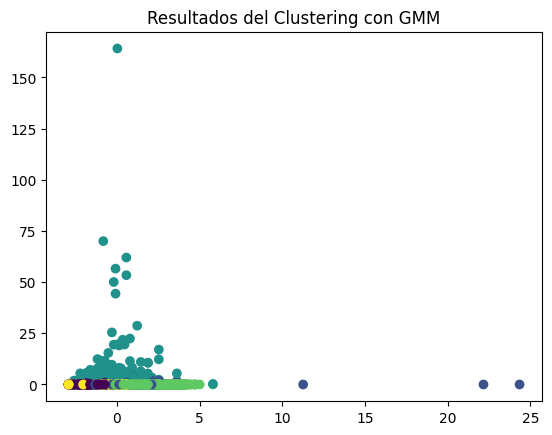

In [ ]:
plt.scatter(prepared_df.iloc[:, 62], prepared_df.iloc[:, 64], c=clusters, cmap='viridis')
plt.title('Resultados del Clustering con GMM')
plt.show()

In [ ]:
plt.scatter(prepared_df.iloc[:, 63], prepared_df.iloc[:, 60], c=clusters, cmap='viridis')
plt.title('Resultados del Clustering con GMM')
plt.show()

NameError: name 'plt' is not defined